># Определение тональности комментариев
>## Подготовил: Кабанов Илья, 22П-2

Целью работы является создание модели на основе рекуррентных нейросетей, предназначенной для бинарной классификации тональности комментариев (позитивный/негативный) с целью последующей фильтрации токсичных или нежелательных сообщений. В ходе выполнения необходимо решить следующие задачи:

**Задачи:**
 - Провести первичный анализ и предварительную обработку текстовых данных.
 - Выполнить токенизацию и векторизацию текстов для подачи в нейросеть.
 - Спроектировать архитектуру нейронной сети.
 - Произвести обучение модели на подготовленных данных.
 - Оценить эффективность классификации с помощью метрик качества. 
  - Сохранить обученную модель и описать сценарий её дальнейшего использования.

## 1. Подключение модулей


In [63]:
import pandas as pd
import numpy as np
import re
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import nltk
from nltk.corpus import stopwords

# Загрузка стоп-слов
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


___

## 2. Анализ данных

In [72]:
df = pd.read_csv(
    'com.csv', 
    sep=',', 
    encoding='utf-8',
    names=['tonality', 'comment', 'extra'],
    header=0,
    dtype=str
)

> Объединяем колонки, тк данные раздвоились:

In [73]:
mask = df['extra'].notna()

In [74]:
df.loc[mask, 'comment'] = df.loc[mask, 'comment'] + ' ' + df.loc[mask, 'extra']
df = df.drop('extra', axis=1)

In [75]:
df.head(10)

,tonality,comment
0,1,скотина! что сказать
1,0,я сегодня проезжала по рабочей и между домами ...
2,0,очередной лохотрон. зачем придумывать очередно...
3,0,"ретро дежавю ... сложно понять чужое сердце , ..."
4,0,а когда мы статус агрогородка получили?
5,0,2 августа поздно вечером нашли вот такую потер...
6,0,вчера надыбала новые стикеры #u2a94ec7fabs#
7,1,",2 заколоть этого плешивого урода что бы крякн..."
8,0,а еще на стоянке никто не проверяет безопаснос...
9,0,"красота..!! если есть, что показать??!! почему..."


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248290 entries, 0 to 248289
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tonality  248290 non-null  object
 1   comment   248290 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


___

In [77]:
def preprocess_text(text):
    text = text.replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('[^a-zA-Zа-яА-Я]+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()
    text = "".join(text)
    return text.strip()

In [78]:
# Очистка текста
df['clean_comment'] = df['comment'].apply(preprocess_text)

In [79]:
# Удаляем стоп-слова
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

df['clean_comment'] = df['clean_comment'].apply(remove_stopwords)

___

## 3. Токенизация

In [80]:
MAX_VOCAB_SIZE = 10000  # Максимальный размер словаря
MAX_SEQUENCE_LENGTH = 100  # Максимальная длина комментария
EMBEDDING_DIM = 100  # Размерность эмбеддингов

In [81]:
# Токенизация
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_comment'])

In [82]:
# Преобразование в последовательности
sequences = tokenizer.texts_to_sequences(df['clean_comment'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [83]:
df.head()

,tonality,comment,clean_comment
0,1,скотина! что сказать,скотина сказать
1,0,я сегодня проезжала по рабочей и между домами ...,сегодня проезжала рабочей домами снитенко гомо...
2,0,очередной лохотрон. зачем придумывать очередно...,очередной лохотрон придумывать очередной налог...
3,0,"ретро дежавю ... сложно понять чужое сердце , ...",ретро дежавю сложно понять чужое сердце лиш ощ...
4,0,а когда мы статус агрогородка получили?,статус агрогородка получили


___

## 4. Обучение моделей

In [84]:
unique_tonalities = df['tonality'].unique()
print(f"Уникальные значения тональности: {unique_tonalities}")
print(f"Количество уникальных значений: {len(unique_tonalities)}")

Уникальные значения тональности: ['1' '0' 'OBSCEN' '2']
Количество уникальных значений: 4


In [85]:
# Посмотрим распределение по классам
print("\nРаспределение по классам:")
print(df['tonality'].value_counts())


Распределение по классам:
tonality
0         203685
1          36826
2           5460
OBSCEN      2319
Name: count, dtype: int64


In [86]:
for tonality in unique_tonalities:
    print(f"\n--- Примеры для класса '{tonality}' ---")
    examples = df[df['tonality'] == tonality]['comment'].head(3)
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example[:100]}...")


--- Примеры для класса '1' ---
1. скотина! что сказать...
2. ,2 заколоть этого плешивого урода что бы крякнул как селезень гандон штопанный всю вакцину ему в бош...
3. долбоебы это фэйк...

--- Примеры для класса '0' ---
1. я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином ( на пустыре) бежала ...
2. очередной лохотрон. зачем придумывать очередной налог на воздух, если можно обьявить инсульт и грипп...
3. ретро дежавю ... сложно понять чужое сердце , лиш ощутить музыкой видимо...

--- Примеры для класса 'OBSCEN' ---
1. ITY эти генеральши знают где соснуть и раздвинуть зад и передок ,позор страны...
2. ITY полизал бы и всунул...
3. ITY моя любит попа игрушкой секс с в попку мою класс...

--- Примеры для класса '2' ---
1. надо было его собаку на заборе повесить ,жалко скотинку конечно но это было бы предсказание......
2. давайте его ;растреляем; в театре на спектакле гнилыми помидорами и все!!...
3. вот растрелять бы этих богослужителей, грабить доверчивых ,

> Можно заметить, что классы 1, 2 - агрессивные. Класс OBSCEN содержит нецензурную лексику. Всё это относим к негативной тональности. А класс 0 - более нейтральный/позитивный

In [ ]:
# Маппинг исходных меток
tonality_mapping = {
    '0': 0,  # нейтральный
    '1': 1,  # агрессивный
    '2': 1,  # негативный
    'OBSCEN': 1  # нецензурная лексика
}
df['tonality'] = df['tonality'].map(tonality_mapping)

In [ ]:
print(df['tonality'].value_counts())
df.head()

tonality
0    203685
1     44605
Name: count, dtype: int64


,tonality,comment,clean_comment
0,1,скотина! что сказать,скотина сказать
1,0,я сегодня проезжала по рабочей и между домами ...,сегодня проезжала рабочей домами снитенко гомо...
2,0,очередной лохотрон. зачем придумывать очередно...,очередной лохотрон придумывать очередной налог...
3,0,"ретро дежавю ... сложно понять чужое сердце , ...",ретро дежавю сложно понять чужое сердце лиш ощ...
4,0,а когда мы статус агрогородка получили?,статус агрогородка получили


> Теперь класс 0 - негативная тональность. Класс 1 - позитивная/нейтральная

In [89]:
unique_tonalities = df['tonality'].unique()
for tonality in unique_tonalities:
    print(f"\n--- Примеры для класса '{tonality}' ---")
    examples = df[df['tonality'] == tonality]['comment'].head(3)
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example[:100]}...")


--- Примеры для класса '1' ---
1. скотина! что сказать...
2. ,2 заколоть этого плешивого урода что бы крякнул как селезень гандон штопанный всю вакцину ему в бош...
3. долбоебы это фэйк...

--- Примеры для класса '0' ---
1. я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином ( на пустыре) бежала ...
2. очередной лохотрон. зачем придумывать очередной налог на воздух, если можно обьявить инсульт и грипп...
3. ретро дежавю ... сложно понять чужое сердце , лиш ощутить музыкой видимо...


In [90]:
# Целевая переменная
y = df['tonality'].values

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42, stratify=y
)

>Вычисляем веса классов для компенсации дисбаланса:

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Веса классов:")
for class_idx, weight in class_weight_dict.items():
    class_name = 'Негативный' if class_idx == 0 else 'Позитивный'
    print(f"  {class_name}: {weight:.4f}")

Веса классов показывают дисбаланс в обучающей выборке:
• Негативные комментарии (вес 0.61) - составляют ~82% выборки
• Позитивные комментарии (вес 2.78) - составляют ~18% выборки

C:\Users\ROG\AppData\Local\Temp\ipykernel_11088\3880722697.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=class_counts.values, palette=palette)


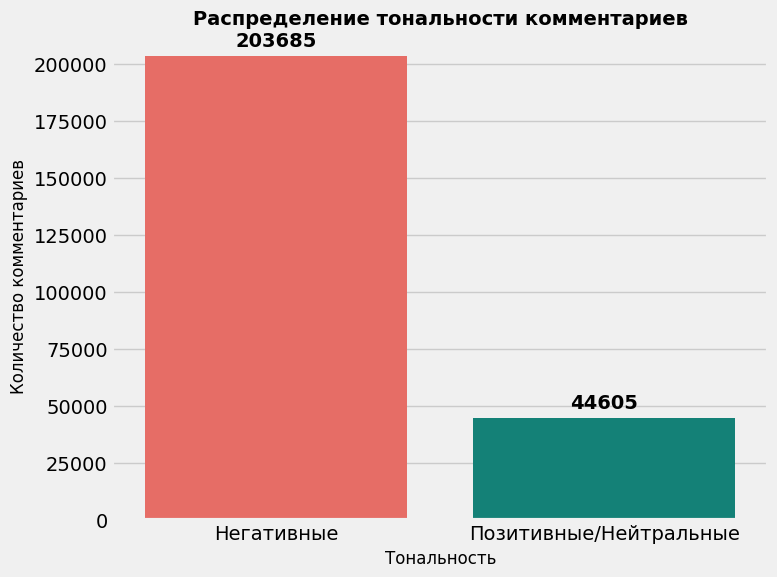

In [94]:
plt.style.use('fivethirtyeight')

class_counts = df['tonality'].value_counts().sort_index()
total = len(df)

colors_ = ["coral", "teal"] if len(class_counts) == 2 else ["deep blue", "blue", "teal"]
palette = sns.xkcd_palette(colors_)

if len(class_counts) == 2:
    labels = ['Негативные', 'Позитивные/Нейтральные']
else:
    labels = [f'Класс {i}' for i in class_counts.index]

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=class_counts.values, palette=palette)

plt.title("Распределение тональности комментариев", fontsize=14, fontweight='bold')
plt.xlabel('Тональность', fontsize=12)
plt.ylabel('Количество комментариев', fontsize=12)

for i, (count, rect) in enumerate(zip(class_counts.values, ax.patches)):
    height = rect.get_height()
    
    ax.text(
        rect.get_x() + rect.get_width()/2, 
        height + total*0.01, 
        f'{count}', 
        ha='center', 
        va='bottom',
        fontweight='bold'
    )


plt.tight_layout()
plt.show()

___

## 5. Рекуррентная нейронная сеть (LSTM)

In [95]:
num_classes = len(df['tonality'].unique())

In [96]:
def build_improved_lstm(vocab_size, embed_dim, input_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=input_len),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

model = build_improved_lstm(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, num_classes)
model.summary()

c:\Users\ROG\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

>Прописываем коллбэки для ранней остановки обучения модели.

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3, 
        min_lr=1e-6,
        verbose=1
    )
]

In [98]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
5587/5587 ━━━━━━━━━━━━━━━━━━━━ 735s 130ms/step - accuracy: 0.9155 - loss: 0.2631 - val_accuracy: 0.9501 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 2/30
5587/5587 ━━━━━━━━━━━━━━━━━━━━ 758s 136ms/step - accuracy: 0.9472 - loss: 0.1893 - val_accuracy: 0.9480 - val_loss: 0.1773 - learning_rate: 0.0010
Epoch 3/30
5587/5587 ━━━━━━━━━━━━━━━━━━━━ 828s 148ms/step - accuracy: 0.9485 - loss: 0.1671 - val_accuracy: 0.9463 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 4/30
5587/5587 ━━━━━━━━━━━━━━━━━━━━ 1026s 184ms/step - accuracy: 0.9501 - loss: 0.1543 - val_accuracy: 0.9387 - val_loss: 0.1989 - learning_rate: 0.0010
Epoch 5/30
5587/5587 ━━━━━━━━━━━━━━━━━━━━ 1026s 184ms/step - accuracy: 0.9540 - loss: 0.1418 - val_accuracy: 0.9456 - val_loss: 0.1891 - learning_rate: 0.0010
Epoch 6/30
5587/5587 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9570 - loss: 0.1260
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5587/5587 ━━━━━━━━━━━━━━━━━━━━ 1065s 191ms

## 6. Оценка модели

In [99]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

1552/1552 ━━━━━━━━━━━━━━━━━━━━ 62s 39ms/step


In [100]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Негативные', 'Позитивные/Нейтральные']))


Classification Report:
                        precision    recall  f1-score   support

            Негативные       0.98      0.96      0.97     40737
Позитивные/Нейтральные       0.83      0.89      0.86      8921

              accuracy                           0.95     49658
             macro avg       0.90      0.92      0.91     49658
          weighted avg       0.95      0.95      0.95     49658


>**Выводы по репорту:**

1. Отличное качество на доминирующем классе (F1=0.97)

2. Высокая общая точность (95%)

3. Мало ложных срабатываний на негативном классе

4. Модель хорошо справляется с дисбалансом (благодаря весам)

5. Метрики на позитивном/нейтральном классе приемлемые (F1=0.86)

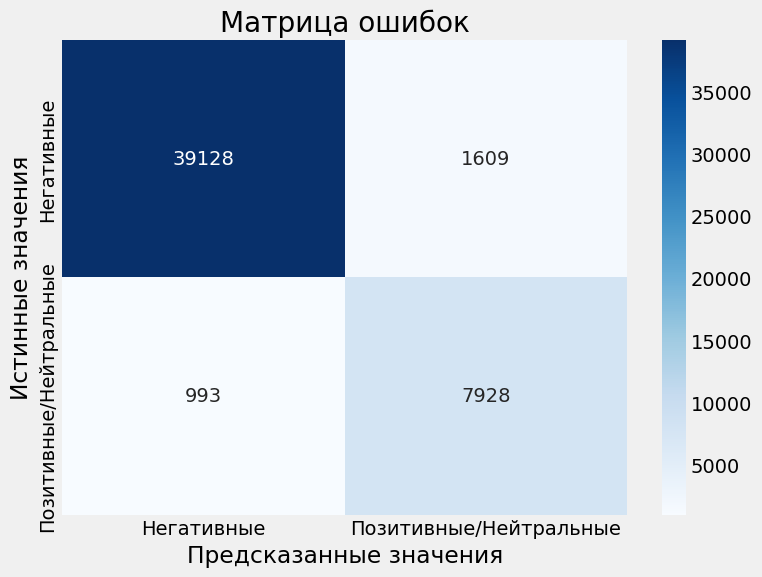

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Негативные', 'Позитивные/Нейтральные'],
            yticklabels=['Негативные', 'Позитивные/Нейтральные'])
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

Модель показала отличные результаты и готова к практическому использованию. Особенно впечатляет, как хорошо она справляется с дисбалансом классов - редкий позитивный класс определяется с F1=0.86, что является очень хорошим показателем.

____

## 7. Сохранение модели и токенизатора

In [102]:
os.makedirs('models', exist_ok=True)

In [103]:
# Сохраняем токенизатор
tokenizer_json = tokenizer.to_json()
with open('models/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

In [104]:
# Сохраняем метаданные
metadata = {
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'max_vocab_size': MAX_VOCAB_SIZE,
    'embedding_dim': EMBEDDING_DIM,
    'num_classes': num_classes,
    'class_names': ['Негативные', 'Позитивные'],
    'class_weights': class_weight_dict
}
with open('models/metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

In [106]:
# Сохраняем модель
model.save('models/lstm_model.h5')
print("Модель сохранена")

Модель сохранена


___

## 8.  Вывод

**Цель работы:**
Разработка и обучение модели на основе двунаправленной LSTM (BiLSTM) для бинарной классификации тональности текстовых комментариев (негативный vs позитивный/нейтральный контент) в задаче автоматической фильтрации нежелательных сообщений.

**Выполненные этапы:**
1. Анализ данных
    - Загрузка датасета com.csv
    - Объединение полей, удаление стоп-слов
    - Выявлен дисбаланс классов
2. Подготовка данных
    - Токенизация с ограничением словаря (10 000 слов)
    - Паддинг последовательностей (100 токенов)
    - Разделение на train/test (80/20)
    - Расчет весов классов: негативные = 0.61, позитивные = 2.78

3. Архитектура нейросети
text
Embedding(10000, 100) → SpatialDropout1D(0.2) → 
BiLSTM(64, return_sequences=True) → BiLSTM(32) → 
Dense(64) → BatchNormalization
4. Обучение
    - Оптимизатор: Adam
    - Loss: sparse_categorical_crossentropy
    - Коллбэки: EarlyStopping (patience=5), ReduceLROnPlateau (patience=3)
    - Эпох: 30 (с ранней остановкой)

**Результаты модели**

Общая точность (accuracy): 95%

Macro avg: precision=0.90, recall=0.92, f1=0.91

Weighted avg: precision=0.95, recall=0.95, f1=0.95

Модель на базе двунаправленной LSTM достигла целевых показателей качества (accuracy = 95%) и эффективно работает в условиях несбалансированной выборки. Полученные результаты позволяют рекомендовать её к использованию в продуктивной среде для автоматической фильтрации нежелательных комментариев.
